# EOSC-Pillar use case: Provenance support in jupyter notebooks 

- [Use Case Context in EOSC Pillar](https://docs.google.com/presentation/d/1mj8fjsHAPUXkIEEGJgOkDMm8MzIK1Htj4VKjl2lxLig/edit#slide=id.p)

Requirements:
- A python 3 installation (a conda based installation is recommended)
- the prov library: pip install prov[dot]
- the graphviz library (optional): conda install graphviz
- the ENVRI+ provenance template expansion tool 
    - clone the repository: git clone https://github.com/EnvriPlus-PROV/EnvriProvTemplates.git
    - change to the git repo directory: cd EnvriProvTemplates
    - python setup.py install
    
- the pyhandle library for registering PIDs in the handle system (EOSC service)
- a running PID collection API, e.g. the EOSC-pillar collection API demo service
    - start with docker run -d -p 8080:8080 kitdm/collection-api:latest
- the fair_data_helpers python script (to be packaged in pip)    

## Step1: import fair_data_helpers and instantiate a provenance template

- the template captures the generic W3C Prov conformant provenance structure, which will be later on filled with the specific information for a specific usage scenario
- A prov template is a standard prov document and can be built based on the prov library, see https://prov.readthedocs.io/en/latest/ for the documentation of this library.  "var" and "vargen" namespaces denote the parts in the prov document which can be substituted by the templating mechanism.
- For illustration purposes the generic template is very simple in this case: an activity, which is attributed to an author generates output data based on input ..

In [1]:
from provtemplates import provconv
import fair_data_helpers

In [2]:
prov_doc = fair_data_helpers.create_prov_template()

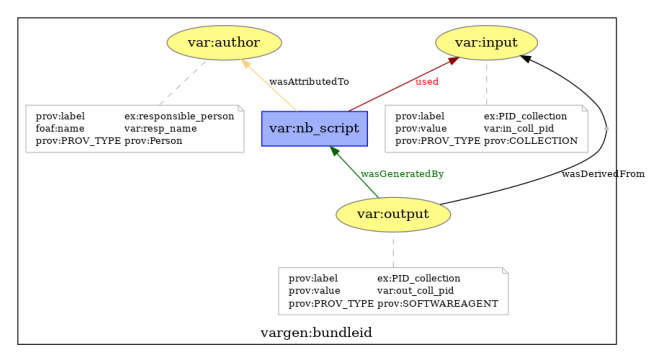

In [3]:
%matplotlib  inline
prov_doc.plot()

## Step 2) Define and collect the input data sets 

- As normally many similiar data sets are used they will be summarized in a collection
- this collection is assigned a collection PID and registered using the PID collection API 
  (assumes running local collection API docker container:  docker run -d -p 8080:8080 kitdm/collection-api:latest)

#### Parameters for the collection PID registration
- a valid handle
- PID metadata characterizing the PID
- a landing page url
- credentials for the handle PID system

In [4]:
handle = "21.T12996/abctest1234"  # a unique identifier with appropriate prefix
metadata_dict = {
        'DESCRIPTION': 'test1 EOSC',
        'CONTACT': 'kindermann@dkrz.de',
        'CREATED': 20211114,
        'TEST':'TRUE'
    }
url = "https://gitlab.dkrz.de/git_page_describing_collection"  # kind of landing page for the PID

cred_path = "/home/stephan/SNAS/SWork/test-prefix.json"  # credentials for PID reg service

pid = fair_data_helpers.register_handle(cred_path, handle,url, metadata_dict)
print("PID registered:", pid)


/home/stephan/miniconda3/envs/meta1/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'epic5.storage.surfsara.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/stephan/miniconda3/envs/meta1/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'epic5.storage.surfsara.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


PID registered: 21.T12996/abctest1234


## Create the collection and register it using the collection API

In [5]:
# input: list of PIDs which define PID collection

pid_list = ["hdl:21.14100/4639c62d-4f4c-4778-8218-03419097f167",
"hdl:21.14100/6c6ebada-50cc-4167-bf75-d4ee8a9cbd33",
"hdl:21.14100/5c7180e1-a82c-4f62-982a-153911d015aa",
"hdl:21.14100/66c23f9f-d0e7-42bf-b82d-49611b95aa87",
"hdl:21.14100/50f7f23d-4f96-4175-bae5-29cddc984953",
"hdl:21.14100/82c0ce5d-c77b-4527-8b19-a333f6e9241a",
"hdl:21.14100/8952d514-fa9d-4323-be43-1e58e3d5c5d1",
"hdl:21.14100/2b34795d-7833-4bd6-b48d-731e91bff3d7",
"hdl:21.14100/b00ad220-fadb-4707-b2af-ab9ae8500442",
"hdl:21.14100/118b040b-df76-435d-ac34-f0210a06e891",
"hdl:21.14100/77b7fedd-ec39-466b-92a3-421e6f68a75f"]

In [6]:
(c_pid,c_url) = fair_data_helpers.create_pid_collection("21.T12996/abctest123",pid_list)

new collection url http://localhost:8080/api/v1/collections/21.T12996/abctest123
http://localhost:8080/api/v1/collections/21.T12996/abctest123/members


## Step 4) Provide specific provenance info and instantiate the template

the use case specifice provenance info needs to be provided:
- author related info (e.g. ORCID, Name, ..)
- the activity
- generated output data sets

In [9]:

# we want to instantiate 2 authors, with different orcids 
entity_dict = {  
    'var:author':['orcid:0000-0002-3494-120X','orcid:1111-1111-1111-111X'],
    'var:output':['ex://21.112/abc111cccddd'],
    'var:input':['ex:21.T12996/abctest1234'], # the registered collection PID
    'var:nb_script':['ex:http://www.github.com/eosc-pillar-usecases/use-c1.git'],           
}

attr_dict = {
    'var:nb_script':['ex:http://www.github.com/eosc-pillar-usecases/use-c1.git'],
    'var:out_coll_pid':['ex:hdl://21.112/abc111cccddd'],
    'var:in_coll_pid':['ex:hdl://21.112/rrrrrrrbc111cccddd'],
}

### Instantiate the PROV template using the binding

In [10]:
# merge the entity and attribute bindings in a singe dictionary
instance_dict = entity_dict.copy()
instance_dict.update(attr_dict)

instance_doc = provconv.instantiate_template(prov_doc,instance_dict)

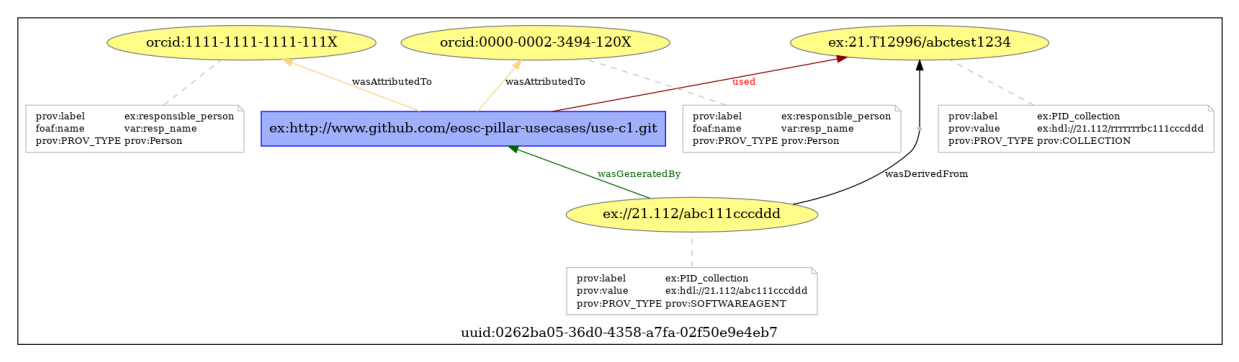

In [11]:
%matplotlib  inline
instance_doc.plot()

## Store the resulting provenance in a standardized format and add to the code e.g. on github
- different serialization formats are provided by the prov library, e.g. json, xml, rdf .. 

In [14]:
instance_doc.serialize("use-case1.rdf",format='rdf')

In [15]:
instance_doc.get_provn()

'document\n  prefix rdf <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\n  prefix ex1 <http://example.org/1/>\n  prefix orcid <http://orcid.org/>\n  prefix foaf <http://xmlns.com/foaf/0.1/>\n  prefix rdfs <http://www.w3.org/2000/01/rdf-schema#>\n  prefix var <http://openprovenance.org/var#>\n  prefix vargen <http://openprovenance.org/vargen#>\n  prefix ex2 <http://example.org/2/>\n  prefix ex <http://example.org/>\n  prefix tmpl <http://openprovenance.org/tmpl#>\n  prefix uuid <urn:uuid:>\n  \n  bundle uuid:0262ba05-36d0-4358-a7fa-02f50e9e4eb7\n    prefix foaf <http://xmlns.com/foaf/0.1/>\n    \n    activity(ex:http://www.github.com/eosc-pillar-usecases/use-c1.git, -, -)\n    entity(ex:21.T12996/abctest1234, [prov:PROV_TYPE="prov:COLLECTION", prov:label="ex:PID_collection", prov:value="ex:hdl://21.112/rrrrrrrbc111cccddd"])\n    entity(orcid:0000-0002-3494-120X, [prov:PROV_TYPE="prov:Person", prov:label="ex:responsible_person", foaf:name="var:resp_name"])\n    entity(orcid:1111-1111-1111-